<a href="https://colab.research.google.com/github/SanGyuk-Raccoon/DACON_1/blob/main/ver_8_Select_CV_seed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier
import xgboost


from sklearn.metrics import log_loss
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [216]:
### 연속형 변수를 구간화하는 함수
###############################################################
def continuous_to_quantile(var, k, DATA) :
  t = 1 / k
  q = 0
  Q = [np.quantile( DATA[var] , q)]

  for i in range(k) :
    q += t
    Q1 = np.quantile( DATA[var] , q)
    Q.append(Q1)

  for i in range(k-1) :
    DATA.loc[(DATA[var] >= Q[i]) & (DATA[var] <= Q[i+1]), f'{var}_Quantile_{k}'] = i
#####################################################################

## 그룹에 대해서 평균을 해주는 함수
#######################################################
def conti_by_cate(GROUP, CONTI, DATA, method) :
  group = GROUP
  var = CONTI
  vec = []
  if method == 'mean' :
    vec = DATA.groupby( group )[ var ].mean()
  elif method == 'min' :
    vec = DATA.groupby( group )[ var ].min()
  elif method == 'max' :
    vec = DATA.groupby( group )[ var ].max()
  elif method == 'skew' :
    vec = DATA.groupby( group )[ var ].skew()
  elif method == 'med' :
    vec = DATA.groupby( group )[ var ].median()
  idx = vec.index

  for i in range(len(vec)) :
    DATA.loc[DATA[group] == idx[i], f'{var}_by_{group}_{method}'] = vec[i]
#######################################################

## Normalization
#######################################################
def norm_scale(data, var) :
  M = data[ var ].max()
  m = data[ var ].min()
  result = (data[ var ] - m) / ( M - m )

  return result

## Standardization
#######################################################
def stand_scale(data, var) :
  M = data[ var ].max()
  sd = data[ var ].std()
  result = ( data[ var ] - M ) / sd

  return result

1.0000000000000635

In [ ]:
# Load DATA
train_raw = pd.read_csv("/content/drive/MyDrive/DACON/[월간 데이콘] 14. 신용카드 사용자 연체 예측 AI/train_update.csv")

test_raw = pd.read_csv("/content/drive/MyDrive/DACON/[월간 데이콘] 14. 신용카드 사용자 연체 예측 AI/test_update.csv")


In [221]:
def pre_processing(DATA) :
  data =  DATA

  ############################################################################################
  

  #############################################################################################
  data = data.drop(['index', 'FLAG_MOBIL'], axis = 1)

  #### 1. gender
  mapping_gender = {
      'F' : 0, # Female = 0
      'M' : 1  # Male = 1
  }
  data['gender_mapping'] = data.gender.map(mapping_gender)


  # 2. car
  mapping_car = {
      'N' : 0,
      'Y' : 1
  }
  data['car_mapping'] = data.car.map(mapping_car)

  # 3. reality
  mapping_reality = {
      'N' : 0,
      'Y' : 1
  }
  data['reality_mapping'] = data.reality.map(mapping_reality)

  ## 
  data['income_total'] = - data['income_total']
  data['income_total'] = norm_scale(data, 'income_total')
  
  data['DAYS_BIRTH'] = - data['DAYS_BIRTH']
  data['DAYS_BIRTH'] = norm_scale(data, 'DAYS_BIRTH')

  data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply( lambda x : - x if x < 0 else 0)
  data['DAYS_EMPLOYED'] = norm_scale(data, 'DAYS_EMPLOYED')

  data['begin_month'] = - data['begin_month']
  data['begin_month'] = norm_scale(data, 'begin_month')


  

  ########################################################################
  var = ['occyp_type', 'income_type',
        'family_type', 'house_type', 'edu_type'
         ]


  ######################################################
  data = data.drop(['gender', 'car', 'reality'] + var, axis = 1)
  

  return data

1575000.0


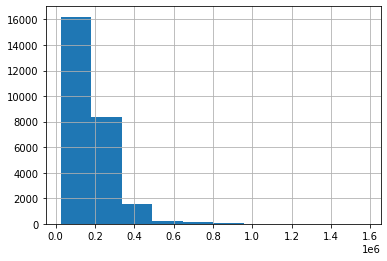

In [ ]:
train_raw['income_total'].hist()
print(train_raw['income_total'].max())

In [222]:
train = pre_processing(train_raw)
train.head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,gender_mapping,car_mapping,reality_mapping
0,0,0.886628,0.355018,0.299688,0,0,0,2.0,0.100000,1.0,0,0,0
1,1,0.857558,0.210638,0.098008,0,0,1,3.0,0.083333,1.0,0,0,1
2,0,0.726744,0.652376,0.282187,0,1,0,2.0,0.366667,2.0,1,1,1
3,0,0.886628,0.423167,0.133138,0,1,0,2.0,0.616667,0.0,0,0,1
4,0,0.915698,0.420244,0.133966,0,0,0,2.0,0.433333,2.0,0,1,1


In [ ]:
n = 1
m = 1
seed = 81288
while m > 0.5 :
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
  
  folds=[]
  for train_idx, valid_idx in skf.split(train, train['credit']):
      folds.append((train_idx, valid_idx))

  xgb_models={}
  xgb_logloss = []
  for fold in range(5):
#      print(f'===================================={fold+1}============================================')
      train_idx, valid_idx = folds[fold]
      X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).loc[train_idx], train.drop(['credit'],axis=1).loc[valid_idx],\
                                      train['credit'][train_idx], train['credit'][valid_idx]                                  
      
      eval_list = [(X_train, y_train),
                    (X_valid, y_valid)]

      xgb_model = xgboost.XGBClassifier(objective = 'multi:softprob',
                                        eval_metric = 'mlogloss',
                                        learning_rate = 0.1,
                                        early_stoppings = 100,
                                        num_class = 3,
                                        max_depth = 10,
                                        n_estimators = 100                                   
                                        ) 
      
      xgb_model.fit(X_train,
                y_train,
                eval_set = eval_list,
                verbose = False
                )
      
      loss = log_loss(y_valid,
                      xgb_model.predict_proba(X_valid))
      xgb_logloss.append(loss)
      xgb_models[fold]=xgb_model
      m = max(abs((xgb_logloss - np.mean(xgb_logloss)) / np.std(xgb_logloss)))
#      print(f'log_loss : {loss:.5f}')
#      print(f'================================================================================\n')

#  print(f'Mean of log_loss : {np.mean(xgb_logloss):.5}')
  print(f'{n} 번째 시도.....seed : {seed}, max : {m:.5f}, mean loss : {np.mean(xgb_logloss):.5}')
  n = n + 1
  seed = int(np.random.randint(0, 100000, size = 1))

# the best seed : 81288


1 번째 시도.....seed : 81288, max : 1.21318, mean loss : 0.74628
2 번째 시도.....seed : 70672, max : 1.54072, mean loss : 0.74565
3 번째 시도.....seed : 59871, max : 1.48969, mean loss : 0.74366
4 번째 시도.....seed : 84818, max : 1.46124, mean loss : 0.74552
5 번째 시도.....seed : 20740, max : 1.52362, mean loss : 0.74572
6 번째 시도.....seed : 87547, max : 1.78384, mean loss : 0.74899
7 번째 시도.....seed : 30173, max : 1.49372, mean loss : 0.74572
8 번째 시도.....seed : 97328, max : 1.80034, mean loss : 0.74481
9 번째 시도.....seed : 23046, max : 1.34775, mean loss : 0.74522
10 번째 시도.....seed : 14428, max : 1.71685, mean loss : 0.74593
11 번째 시도.....seed : 67802, max : 1.52379, mean loss : 0.74837
12 번째 시도.....seed : 72577, max : 1.77433, mean loss : 0.7463
13 번째 시도.....seed : 57301, max : 1.59952, mean loss : 0.74814
14 번째 시도.....seed : 99102, max : 1.57927, mean loss : 0.74741
15 번째 시도.....seed : 22754, max : 1.45359, mean loss : 0.74612
16 번째 시도.....seed : 22697, max : 1.55408, mean loss : 0.74803
17 번째 시도.....seed 

KeyboardInterrupt: ignored

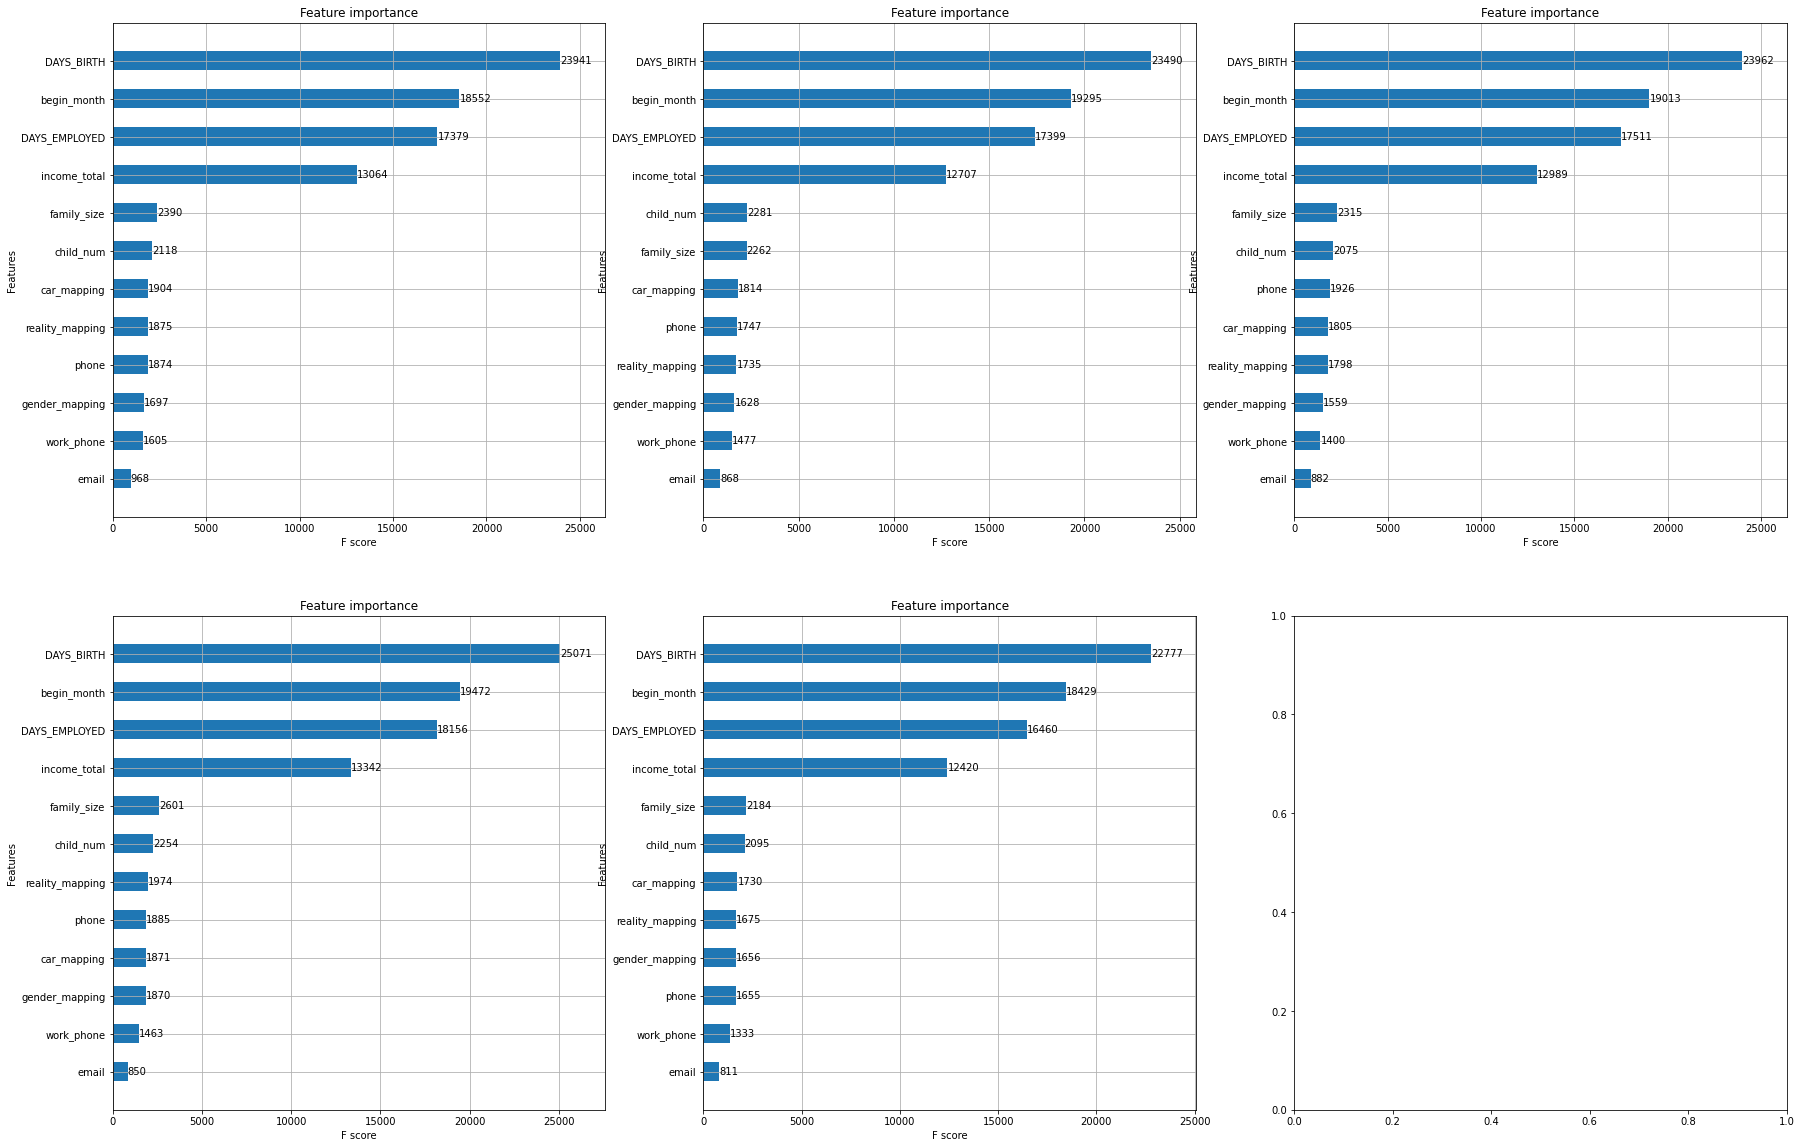

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))
for i in range(5) :
  xgboost.plot_importance(xgb_models[i], max_num_features=50, height=0.5, ax=ax[i%2, i%3],importance_type='weight')
plt.show()

# Get seed 81288

In [211]:
train.head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,gender_mapping,car_mapping,reality_mapping
0,0,0.149133,0.355018,0.299688,0,0,0,2.0,0.100000,1.0,0,0,0
1,1,0.590837,0.210638,0.098008,0,0,1,3.0,0.083333,1.0,0,0,1
2,0,2.578501,0.652376,0.282187,0,1,0,2.0,0.366667,2.0,1,1,1
3,0,0.149133,0.423167,0.133138,0,1,0,2.0,0.616667,0.0,0,0,1
4,0,-0.292570,0.420244,0.133966,0,0,0,2.0,0.433333,2.0,0,1,1
